In [1]:
%load_ext Cython

import matplotlib.pyplot as plt

In [152]:
%%cython
# use -a flag to output analysis cell

cimport cython

import numpy as np
cimport numpy as np

from libc.math cimport pow, pi, sqrt, cos

cdef extern from "complex.h":
    long double complex csqrtl( long double complex)
    long double complex cpowl( long double complex, long double complex)

cdef extern from "tgmath.h":   
    long double complex cexpl( long double complex)

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_parratt2(double wavelength,np.ndarray[np.double_t,ndim=1] z, np.ndarray[np.complex128_t,ndim=2] layer,np.ndarray[np.double_t,ndim=1] alphai):
    cdef double k0 = 2*pi/wavelength
    cdef int n = alphai.shape[0]
    cdef int m = layer.shape[0]
    cdef np.ndarray[np.complex128_t,ndim=2] X = np.empty([m,1],dtype=np.complex128)
    cdef np.ndarray[np.complex128_t,ndim=2] Rf = np.empty([n,1],dtype=np.complex128)
    cdef np.ndarray[np.complex128_t,ndim=2] kz = np.empty([m,1],dtype=np.complex128)
    cdef int idx = 0
    cdef int i, k
    cdef int ii
    cdef double a
    cdef double complex c = 0+2j
    for k in range(n):
        # z-component of wavevector
        a = alphai[k]
        kz = k0*np.sqrt(np.square(layer)-pow(cos(a),2))
#         print(kz[0:m].shape, kz[1:m+1].shape)
#         print(kz.shape, kz[0:-1].shape)
        r = (kz[0:(m-1)] - kz[1:m+1])/(kz[0:(m-1)] + kz[1:m+1])
        for i in range(m-2,-1,-1):
            X[i] = (cexpl(-c*kz[i]*z[i]) * 
                    (r[i]+X[i+1]*cexpl(c*kz[i+1]*z[i])) / 
                    (1+r[i]*X[i+1]*cexpl(c*kz[i+1]*z[i])))
        Rf[idx] = X[0]
        idx += 1
    return Rf



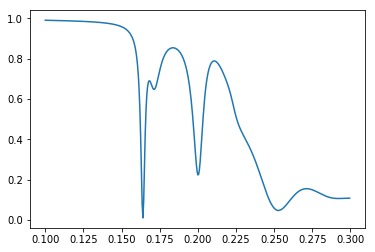

In [139]:
Rf = cy_parratt2(1.54,z_tot,layer_tot,alphai)
plt.plot(alphai*180/np.pi,np.abs(Rf)**2)
plt.show()

In [153]:
from numba import jit

@jit
def parratt2(wavelength,z,layer,alphai):
    k0 = 2*np.pi/wavelength
    X = np.zeros((len(layer),1),dtype=np.complex_)
    Rf = np.zeros((len(alphai),1),dtype=np.complex_)
    idx = 0
    for k in alphai:
        # z-component of wavevector
        kz = k0*np.sqrt(np.square(layer)-np.square(np.cos(k)))
#         print(kz.shape)
        r = (kz[0:-1] - kz[1:len(layer)+1])/(kz[0:-1] + kz[1:len(layer)+1])
        for i in range(len(layer)-2,-1,-1):
            X[i] = (np.exp(-2.j*kz[i]*z[i]) * 
                    (r[i]+X[i+1]*np.exp(2.j*kz[i+1]*z[i])) / 
                    (1+r[i]*X[i+1]*np.exp(2.j*kz[i+1]*z[i])))
        Rf[idx] = X[0]
        idx += 1
    return Rf

In [23]:
# Wavelength and Material parameters
xlambda = 1.54 # wavelength in angstroms

# Silicon
delta_Si = 7.56*10**(-6)
beta_Si = delta_Si/40.
n_Si = complex(1 - delta_Si, beta_Si)

# Polystyrene
delta_PS = 3.5*10**(-6)
beta_PS = delta_PS/200.
tfilm = 2000 # thickness in angstroms
n_PS = complex(1-delta_PS, beta_PS)

# Polystyrene
delta_PS = 3.5*10**(-6)
beta_PS = delta_PS/200.
n_film = complex(1-delta_PS, beta_PS)
t_film = 500
detail = 4
num_slice = t_film/detail
# print(num_slice)
slice_thick = t_film/num_slice
layers1 = np.arange(0,-t_film-slice_thick,-slice_thick)
layer1 = np.ones((len(layers1),1),dtype=np.complex_)*n_film
# Gold
delta_G = 2.9912*10**(-5)
beta_G = 2.2073*10**(-6)
n_film = complex(1-delta_G, beta_G)
t_film = 10
num_slice = t_film/detail
slice_thick = t_film/num_slice
layers2 = np.arange(0,-t_film-slice_thick,-slice_thick)
layer2 = np.ones((len(layers2),1),dtype=np.complex_)*n_film
layers2 = layers2+layers1[-1]
layers3 = layers1+layers2[-1]

z_tot = np.concatenate((layers1, layers2, layers3))
layer_tot = np.concatenate((layer1, layer2, layer1))

delta_Si = 7.56*10**(-6)
beta_Si = delta_Si/40.
n_Si = complex(1 - delta_Si, beta_Si)
layer_tot[0] = 1 + 0.j
layer_tot[-1] = n_Si

In [154]:
alphai = np.arange(0.1,0.3,.0005)/180*np.pi
%timeit parratt2(1.54,z_tot,layer_tot,alphai)
%timeit cy_parratt2(1.54,z_tot,layer_tot,alphai)
# Rf = cy_parratt2(1.54,z_tot,layer_tot,alphai)
# plt.plot(alphai*180/np.pi,np.abs(Rf)**2)
# plt.show()

39.8 ms ± 2.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.72 s ± 86.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


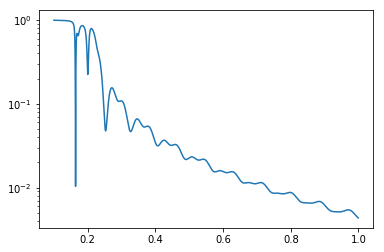

In [156]:
alphai = np.arange(0.1,1,.0005)/180*np.pi
Rf = parratt2(1.54,z_tot,layer_tot,alphai)
plt.semilogy(alphai*180/np.pi,np.abs(Rf)**2)
plt.show()